In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers_v2 import kmeans_tasks, dist, NumpyEncoder


In [5]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4 #Check the celery also uses 4 workers!!!

In [19]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, shuffle =False)

In [20]:
Ys

array([0, 0, 0, ..., 2, 2, 2])

In [22]:
mydata= [{"points": x, "label": y} for x,y in zip(Xs,Ys)]

In [23]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

1600
[ 3.89501749 -6.52095144] 0


In [24]:
# Split the sequence in a number of chunks and process those independently.

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])


In [25]:
len(Xsubseqs[0])

400

In [26]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[ 9.4878856 ,  0.        ],
        [ 0.        , -2.80139897]])

In [27]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[ 5.14295861 -0.27412855]
 [ 0.70840272 -1.1090598 ]
 [ 4.37897125 -1.78183226]]


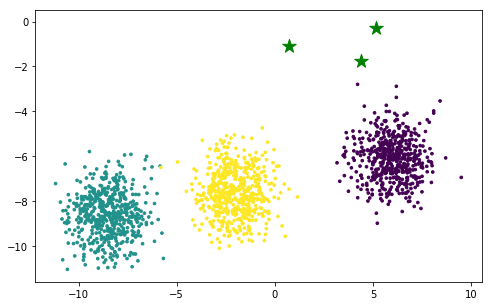

In [28]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [29]:
len([actdata['label'] for actdata in mydata])

1600

In [30]:
print(C)
print(C.shape)

[[ 5.14295861 -0.27412855]
 [ 0.70840272 -1.1090598 ]
 [ 4.37897125 -1.78183226]]
(3, 2)


### Distributed Kmeans

In [34]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)

Initial Centroids
[[ 8.44153721 -1.00742738]
 [ 8.70470401 -1.2264913 ]
 [ 0.4694975  -1.2076952 ]]


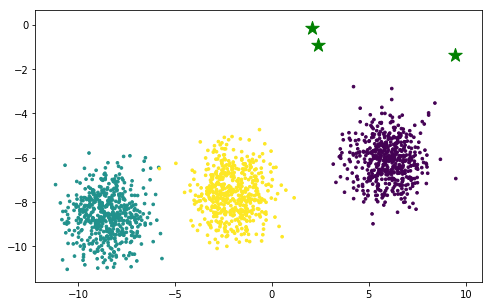

In [35]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =15

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [36]:
#Let us upload data to the workers
response = group(kmeans_tasks.s(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': seq,'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 

response.get()

['success', 'success', 'success', 'success']

[[[6.511795544729383, -6.140687303295975], [0.0, 0.0], [4.931855983712069, -6.088356572038017]], [[0.0, 0.0], [0.0, 0.0], [-6.296178325616919, -8.300041561721542]], [[0.0, 0.0], [0.0, 0.0], [-2.1184011368074422, -7.655201549019662]], [[6.477753925742927, -6.096151192921002], [0.0, 0.0], [-6.6248480479939085, -8.175732873109519]]]
[[263, 0, 137], [0, 0, 400], [0, 0, 400], [91, 0, 309]]
num_points in clusters: [ 354    0 1246]


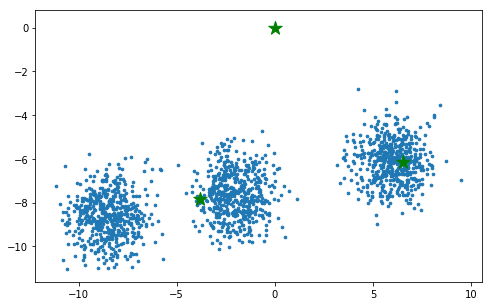

[[[0.0, 0.0], [0.0, 0.0], [-6.296178325616919, -8.300041561721542]], [[0.0, 0.0], [0.0, 0.0], [-2.1184011368074422, -7.655201549019662]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]]]
[[0, 0, 400], [0, 0, 400], [134, 0, 266], [400, 0, 0]]
num_points in clusters: [ 534    0 1066]


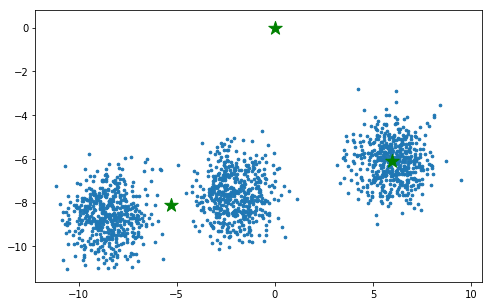

[[[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.4810998541897358, -7.246985819124166], [0.0, 0.0], [-6.313163985215432, -8.302680799171661]], [[0.9308117102617688, -7.644905047835878], [-0.35392528268928886, -5.2776122110679635], [-2.1472412716340066, -7.673311323744276]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]]]
[[134, 0, 266], [1, 0, 399], [2, 3, 395], [400, 0, 0]]
num_points in clusters: [ 537    3 1060]


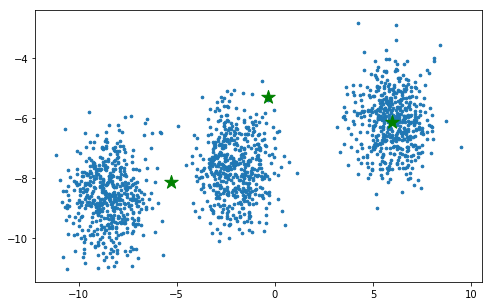

[[[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-1.3749568615442387, -7.257092166117624], [-7.604351119864087, -8.577281274477013]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[134, 0, 266], [0, 84, 316], [400, 0, 0], [134, 0, 266]]
num_points in clusters: [668  84 848]


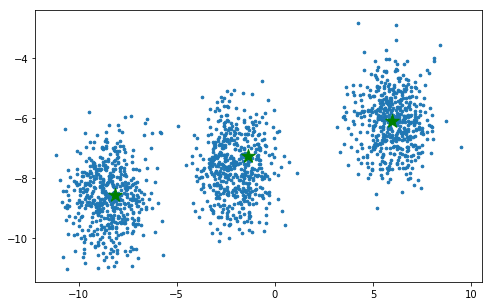

[[[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]]]
[[0, 400, 0], [400, 0, 0], [0, 132, 268], [0, 400, 0]]
num_points in clusters: [400 932 268]


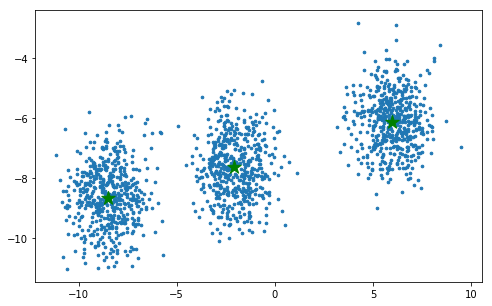

[[[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]]]
[[0, 132, 268], [0, 400, 0], [134, 0, 266], [400, 0, 0]]
num_points in clusters: [534 532 534]


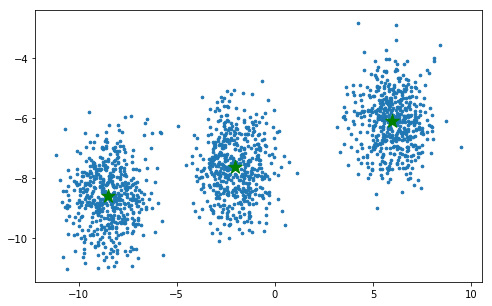

[[[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]]]
[[134, 0, 266], [0, 400, 0], [400, 0, 0], [0, 132, 268]]
num_points in clusters: [534 532 534]


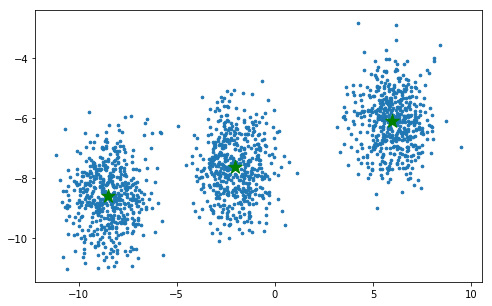

[[[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[0, 400, 0], [400, 0, 0], [0, 132, 268], [134, 0, 266]]
num_points in clusters: [534 532 534]


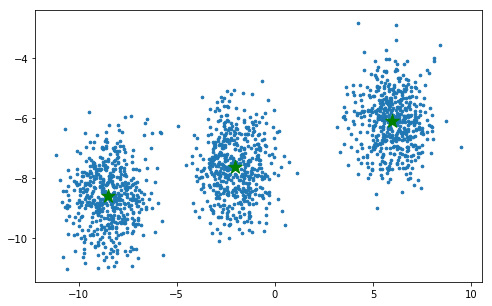

[[[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]]]
[[0, 132, 268], [400, 0, 0], [134, 0, 266], [0, 400, 0]]
num_points in clusters: [534 532 534]


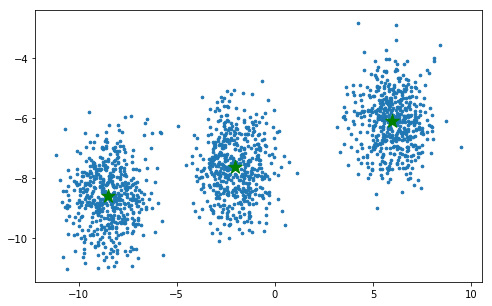

[[[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[400, 0, 0], [134, 0, 266], [0, 132, 268], [134, 0, 266]]
num_points in clusters: [668 132 800]


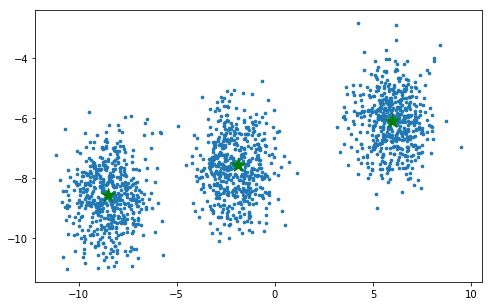

[[[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]]]
[[400, 0, 0], [0, 132, 268], [134, 0, 266], [0, 400, 0]]
num_points in clusters: [534 532 534]


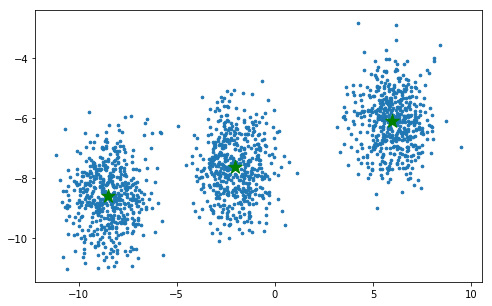

[[[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[400, 0, 0], [0, 132, 268], [0, 400, 0], [134, 0, 266]]
num_points in clusters: [534 532 534]


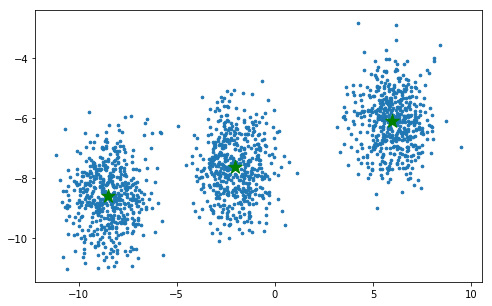

[[[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]]]
[[0, 132, 268], [400, 0, 0], [134, 0, 266], [0, 400, 0]]
num_points in clusters: [534 532 534]


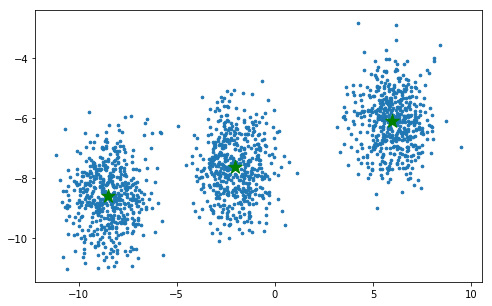

[[[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[400, 0, 0], [0, 132, 268], [0, 400, 0], [134, 0, 266]]
num_points in clusters: [534 532 534]


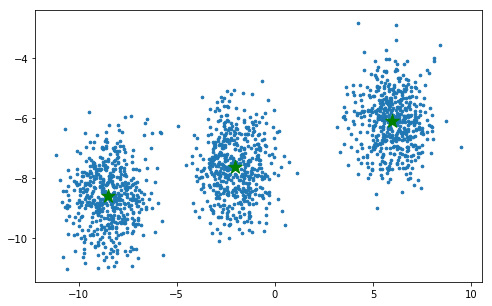

[[[0.0, 0.0], [-1.864142324522205, -7.558751915362459], [-8.479121430633715, -8.665154372614817]], [[0.0, 0.0], [-2.1184011368074422, -7.655201549019662], [0.0, 0.0]], [[5.970666245080948, -6.122764027840127], [0.0, 0.0], [0.0, 0.0]], [[5.956521374908092, -6.048890205873987], [0.0, 0.0], [-8.480362044455617, -8.535714017893]]]
[[0, 132, 268], [0, 400, 0], [400, 0, 0], [134, 0, 266]]
num_points in clusters: [534 532 534]


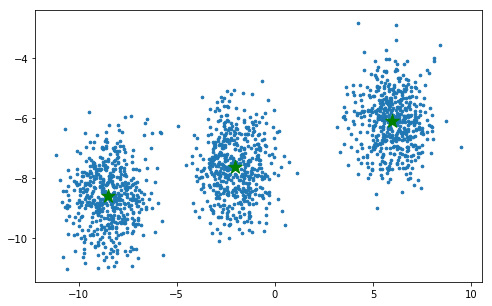

In [37]:
for iter in range(0, n_iter):    
    lazy_partials_EMstep = group(kmeans_tasks.s(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_EMstep = lazy_partials_EMstep.get() # will wait for the tasks to return
    
    #all wrokers are done with their tasks
    partials_C=[json.loads(seq)['C'] for seq in partials_EMstep]
    print(partials_C)
    partials_num_points=[json.loads(seq)['num_points'] for seq in partials_EMstep]
    print(partials_num_points)
    
    #aggregation by th server
    C=np.zeros([n_clusters,n_features])
    for i in range(n_clusters):
        for j in range(n_workers):
             C[i,:]=C[i,:]+partials_num_points[j][i]*np.array(partials_C[j][i])

    num_points=np.sum(np.array(partials_num_points),0)
    print('num_points in clusters:', num_points)
    
    for i in range(n_clusters):
        if num_points[i]>0:
            C[i,:]=C[i,:]/num_points[i]
            
    plt.rcParams['figure.figsize'] = (8, 5)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
